How to Run Code/ Produce plots
- Run Parts 0 and 1 (imports and define functions)
- Run Part 2 if you want to produce plots 
    - input df_0, df_20, or df_40 along with the temperature value = 0,20 or 40
    - Set evt to true or false depending on which plots you want
        subplots = True: Produce 1 plot for each SOC
        subsubplots = True : Produce 4 plots for each SOC, i.e. 1 for each pulse within the SOC
- Run Part 3 to output a file containing the indices of the start and end of each pulse

- Run the Part2Modelling file to answer the questions

# 0. Imports

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [24]:
df_0 = pd.read_csv('Data/Model_Training_Data_0.csv')
df_20 = pd.read_csv('Data/Model_Training_Data_20.csv')
df_40 = pd.read_csv('Data/Model_Training_Data_40.csv')
df_0.columns = ["Time", "Current", "Voltage"]
df_20.columns = ["Time", "Current", "Voltage"]
df_40.columns = ["Time", "Current", "Voltage"]

# Create a Current_Change column
df_40["Current_Change"] = df_40["Current"].diff().astype('float64')
df_20["Current_Change"] = df_20["Current"].diff().astype('float64')
df_0["Current_Change"] = df_0["Current"].diff().astype('float64')



 # 1. Define functions

#### Function to get subsection

In [25]:
""" One dataset includes charge and discharge sets at 9 different SOCs
This function takes one dataset, and returns a list of the indices correponding 
to the start and end of each SOC. 
The split is done by starting the index after the steady discharge that reduces SOC by 10%,
and ending the index once the 4 charge/discharge pulse at a given SOC is complete.
"""
def get_subsections(df,temp):
    time = df.Time
    current = df.Current
    voltage = df.Voltage

    subsections = []
    start_idx = None
    end_idx = None
    is_subsection = False

    # Get the start and end of each SOC
    # loop over the signal
    for i in range(len(time)):
        # check if current is negative and subsection is not ongoing
        if current[i] < 0 and not is_subsection:
            start_idx = i
            is_subsection = True
        # check if current is zero and subsection is ongoing
        elif current[i] == 0 and is_subsection:
            # check if zero current has persisted for at least 5000 seconds
            if time[i] - time[start_idx] >= 5000:
                # check if current has taken on at least 4 unique positive values since start of subsection
                if len(np.unique(current[start_idx:i])) >= 4:
                    end_idx = i
                    subsections.append((int(start_idx*99.9/100), end_idx))
                    is_subsection = False


    # cout the number of negative values in each subsection in the current signal. If this value is above 1000 remove the subsection from the list
    new_subsections = []
    for i in range(len(subsections)):
        start_idx, end_idx = subsections[i]
        if (len(np.where(current[start_idx:end_idx] < 0)[0]) < 1000):
            new_subsections.append(subsections[i])


    if temp == 0:
        new_subsections.append((410000,460000))
        new_subsections.append((474000,513015))
        new_subsections[-3] = (new_subsections[-3][0], int(new_subsections[-3][1]*1.02))

    return new_subsections

#### Function to plot subsections

In [26]:
"""" This function takes the output of the above get_subsections function
and plots the I-t and V-t graphs with appropriate titles and labels
"""
# Plot time vs current and time vs voltage for each subsection
def plot_subsections(subsections,df,temp):
    time = df.Time
    current = df.Current
    voltage = df.Voltage
    for i, subsection in enumerate(subsections):
        start_idx, end_idx = subsection
        fig, ax = plt.subplots(2, 1, figsize=(10, 6))
        ax[0].plot(time[start_idx:end_idx], current[start_idx:end_idx])
        ax[0].set_title('Current vs Time for Temp {temp} SOC ' + str(90 - 10*i) + "%")
        ax[0].set_xlabel('Time (s)')
        ax[0].set_ylabel('Current (A)')
        ax[0].grid(True)
        ax[1].plot(time[start_idx:end_idx], voltage[start_idx:end_idx])
        ax[1].set_title('Voltage vs Time for Temp {temp} SOC ' + str(90 - 10*i) + "%")
        ax[1].set_xlabel('Time (s)')
        ax[1].set_ylabel('Voltage (V)')
        ax[1].grid(True)
        plt.subplots_adjust(hspace=0.25)
        fig.subplots_adjust(hspace=0.4)

#### Function to get subsubsections

In [27]:
""" This function takes the start and end of each test at a single SOC, and
returns start and end indices corresponding to each charge/discharge pulse
Each SOC has 4 charge/discharge pulses, so the output is a list of 4 tuples
"""
def get_subsubsections(subsections,df, offset=500):
    subsubs = []
    for sub in subsections:
        df_new = df[sub[0]:sub[1]]
        df_ind = df_new[df_new.Current_Change < -0.1]
        indices = df_ind.index.to_list()
        subsubs.append([(indices[i*2]-offset, indices[i*2+1]+offset) for i in range(len(indices)//2)])
    return subsubs

#### Functoin to plot subsubsections

In [28]:
""" This function receives the indices of individual pulses in the dataset from the above
function and plots the I-t and V-t graphs for each charge/discharge pulse

"""
# Plot time vs current and time vs voltage for each subsection
def plot_subsubsections(subsections,df,temp):
    time = df.Time
    current = df.Current
    voltage = df.Voltage

    for i in range(len(subsections)):
        current_subsections = subsections[i]
        for k in range(len(current_subsections)):
            start_idx, end_idx = current_subsections[k]
            fig, ax = plt.subplots(2, 1, figsize=(10, 6))
            ax[0].plot(time[start_idx:end_idx], current[start_idx:end_idx])
            ax[0].set_title(f'Current vs Time for Temp {temp} SOC ' + str(90 - 10*i) + "% Pulse #" + str(k+1))
            ax[0].set_xlabel('Time (s)')
            ax[0].set_ylabel('Current (A)')
            ax[0].grid(True)
            ax[1].plot(time[start_idx:end_idx], voltage[start_idx:end_idx])
            ax[1].set_title(f'Voltage vs Time for Temp {temp} SOC' + str(90 - 10*i) + "% Pulse #" + str(k+1))
            ax[1].set_xlabel('Time (s)')
            ax[1].set_ylabel('Voltage (V)')
            ax[1].grid(True)
            plt.subplots_adjust(hspace=0.25)
            fig.subplots_adjust(hspace=0.4)

##### Overall Plotting function

In [29]:
""" This function plots graphs of a given dataset for the whole test, and zoomed in versions for each SOC and Pulse based on
input parameters.
"""
def plot_current_voltage(df, temp, color="g", current = True, voltage =True, overall_plot=True, subplots = True, subsubplots = True):
    
    if overall_plot:
        fig, ax = plt.subplots(2, 1, figsize=(18, 12))
        if current:
            ax[0].plot(df.Time, df.Current, c=color)
            ax[0].set_title('Current vs Time at Temperature: ' + str(temp) + 'C')
            ax[0].set_xlabel('Time (s)')
            ax[0].set_ylabel('Current (A)')
            ax[0].grid(True)
            ax[0].set_xticks(np.linspace(0, df['Time'].max(), 40))
            ax[0].tick_params(axis='x', rotation=90)

        if voltage:
            ax[1].plot(df.Time, df.Voltage,c=color)
            ax[1].set_title('Voltage vs Time at Temperature: ' + str(temp) + 'C')
            ax[1].set_xlabel('Time (s)')
            ax[1].set_ylabel('Voltage (V)')
            ax[1].grid(True)
            ax[1].set_xticks(np.linspace(0, df['Time'].max(), 40))
            ax[1].tick_params(axis='x', rotation=90)

        plt.subplots_adjust(hspace=0.25)


    subsections = get_subsections(df,temp)

    if subplots:
        plot_subsections(subsections,df,temp)

    subsubsections  = get_subsubsections(subsections, df)
    if subsubplots:
        plot_subsubsections(subsubsections, df,temp)


    return subsubsections
        


# 2. Plotting

C:\Users\feyzi\AppData\Local\Temp\ipykernel_26216\2541108275.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2, 1, figsize=(10, 6))


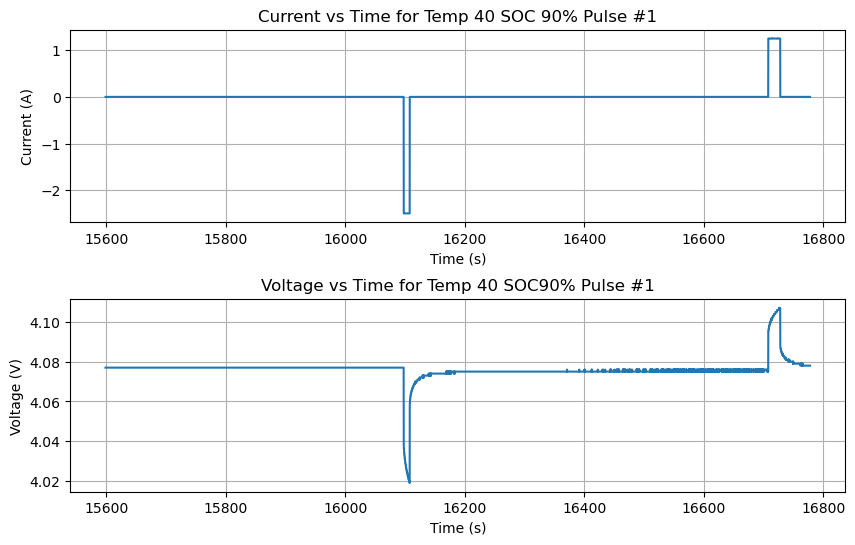

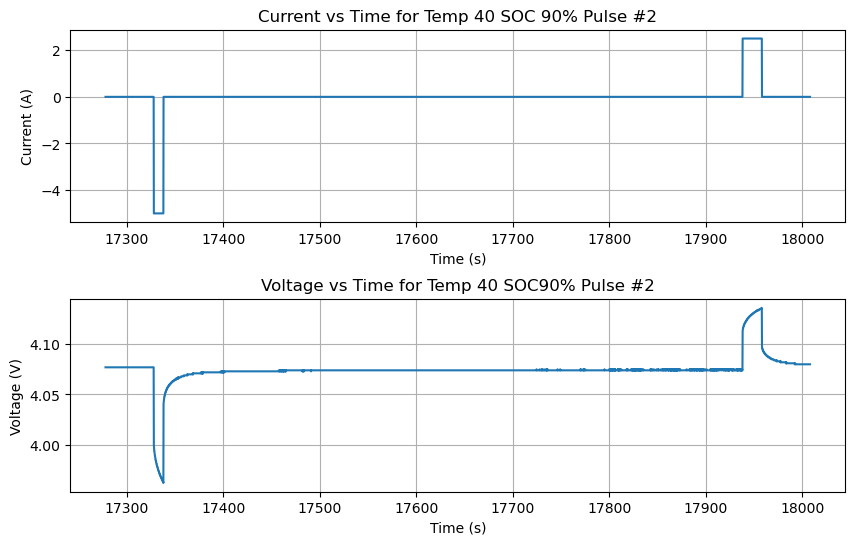

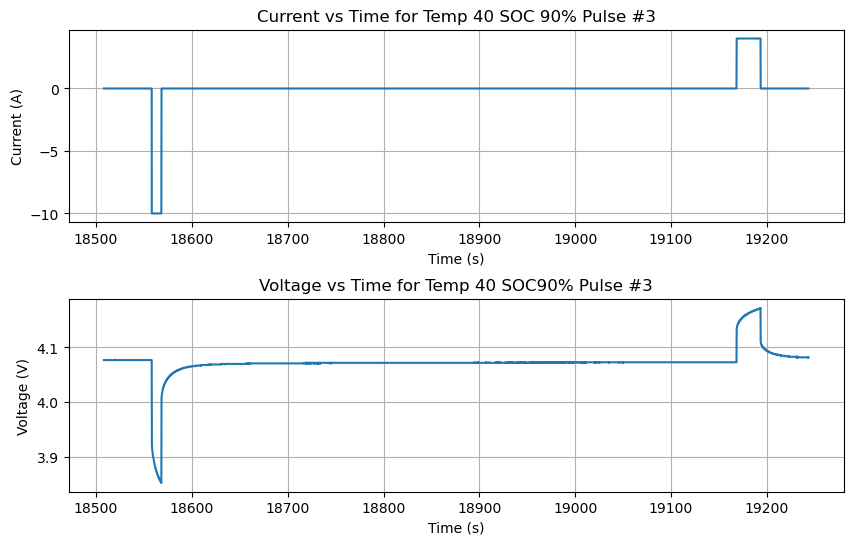

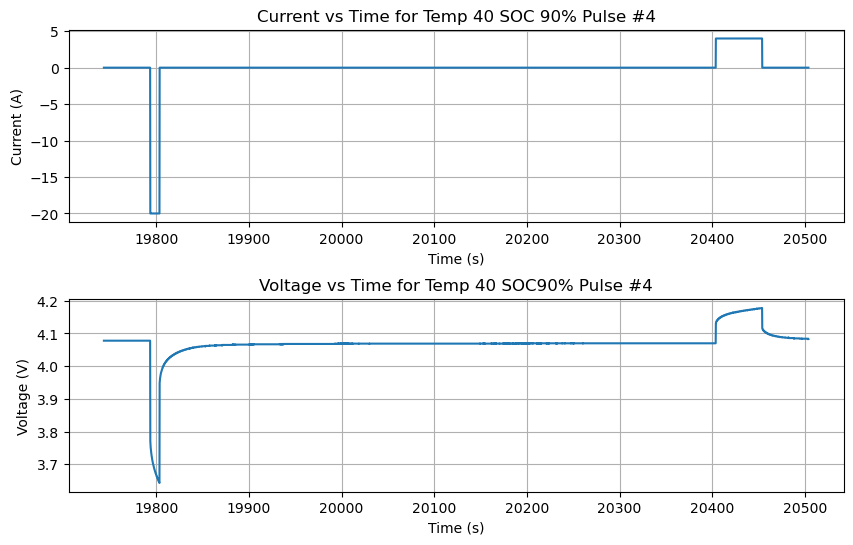

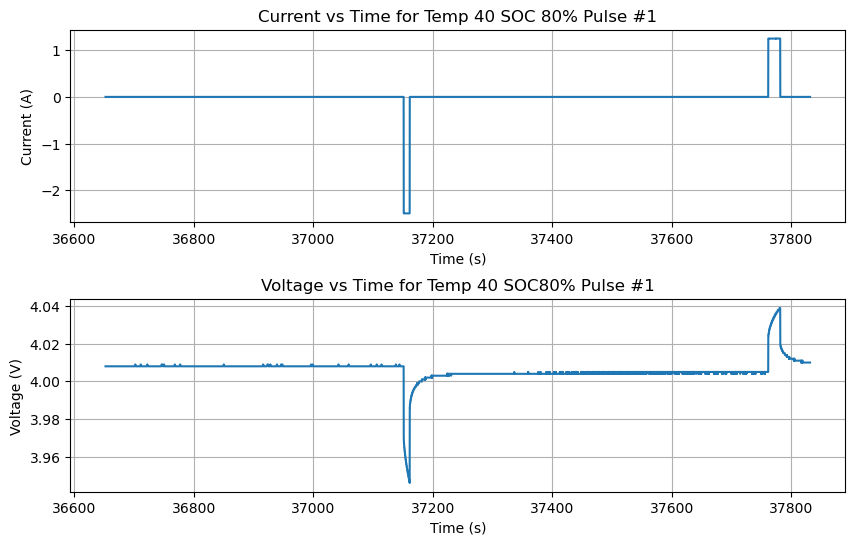

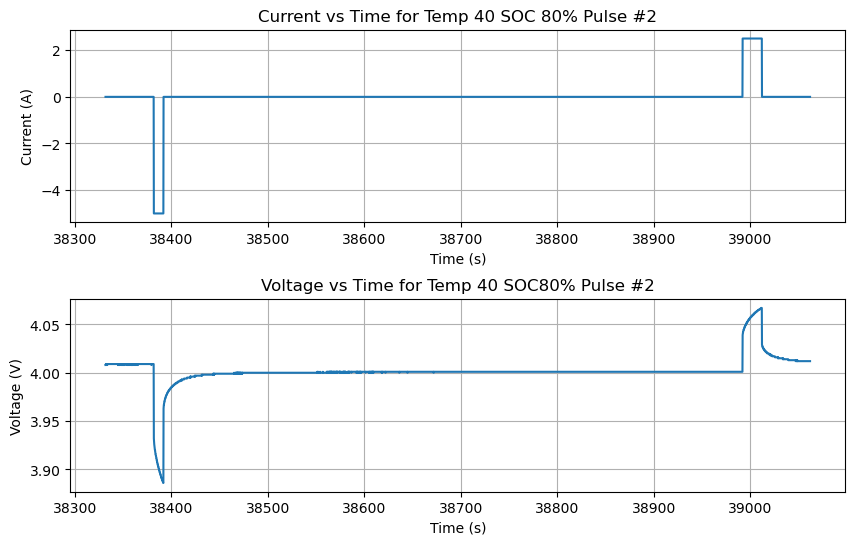

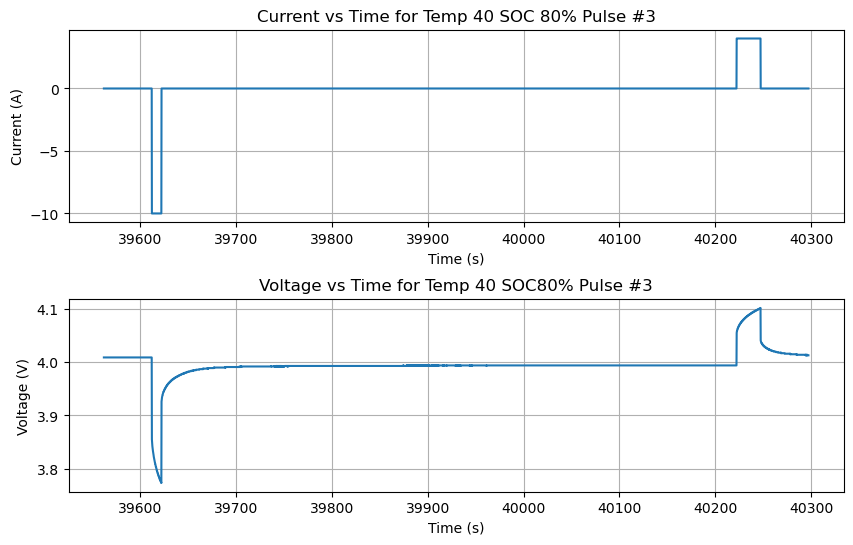

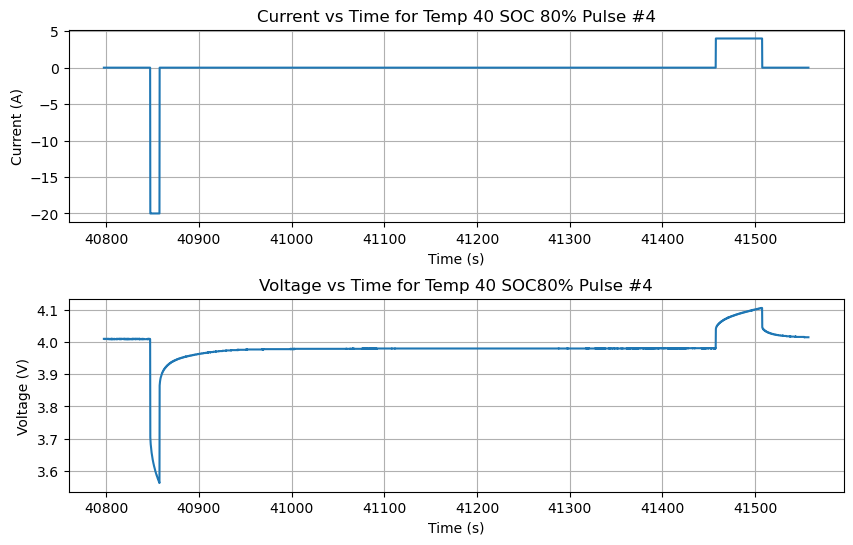

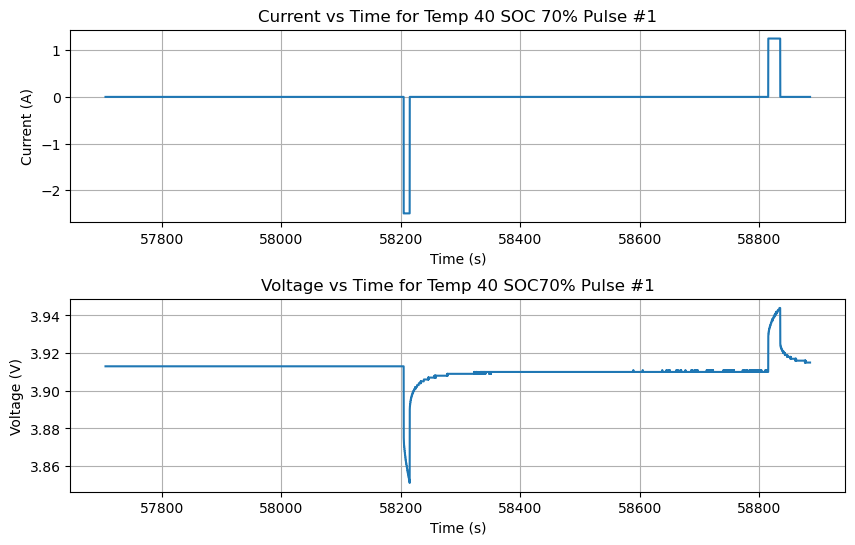

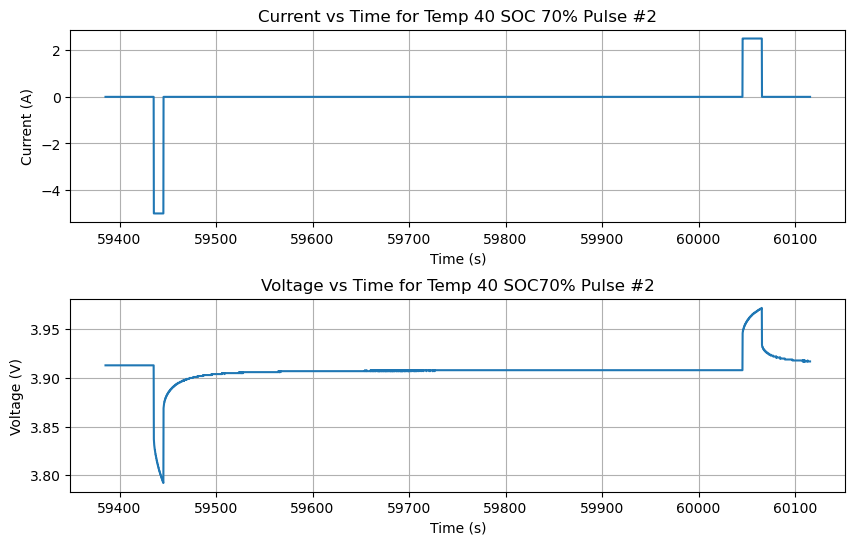

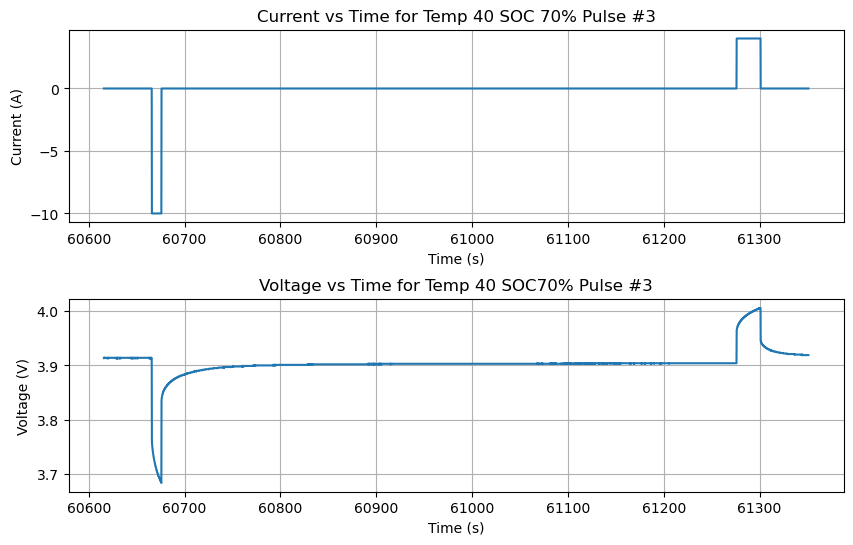

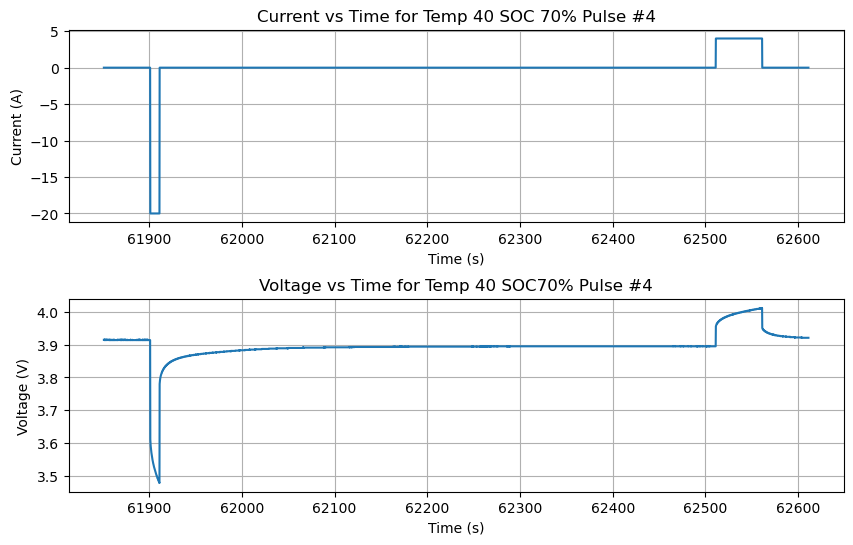

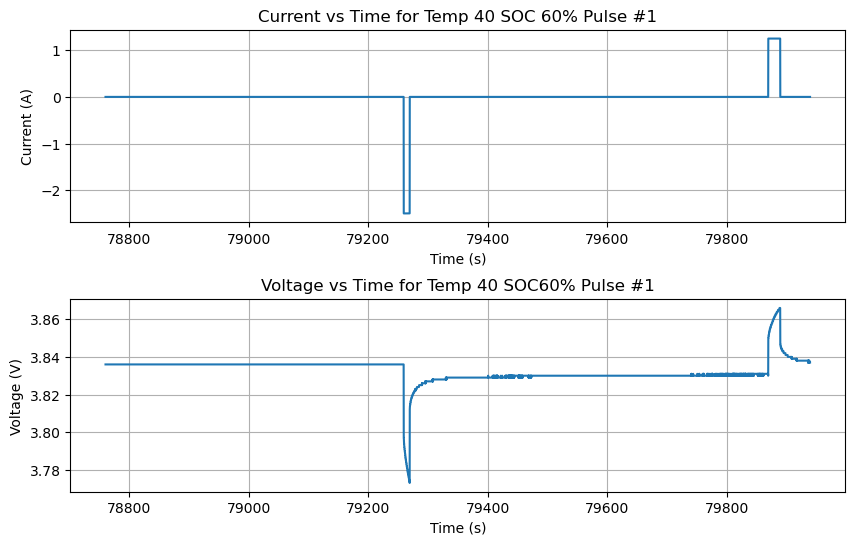

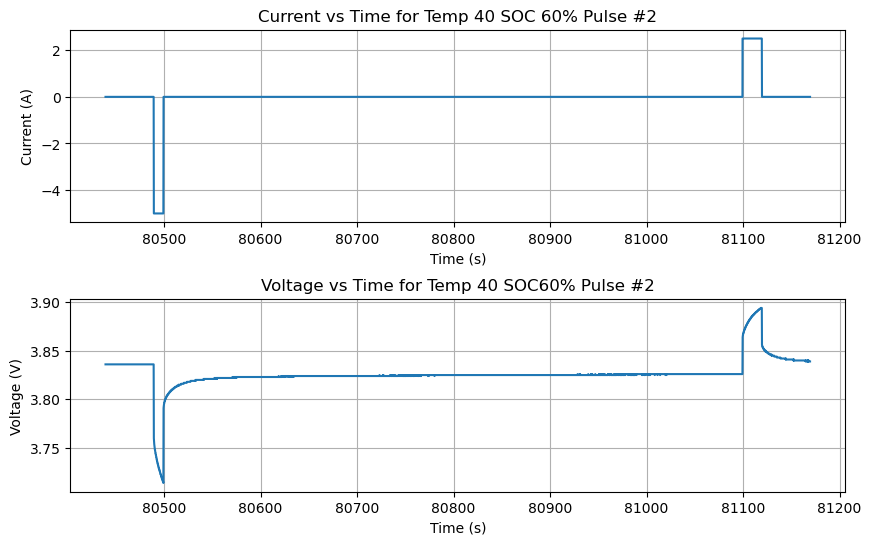

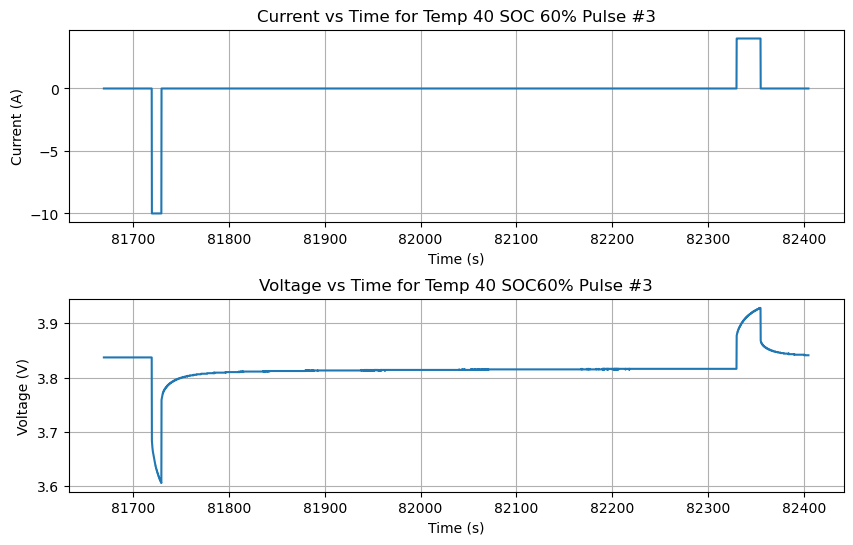

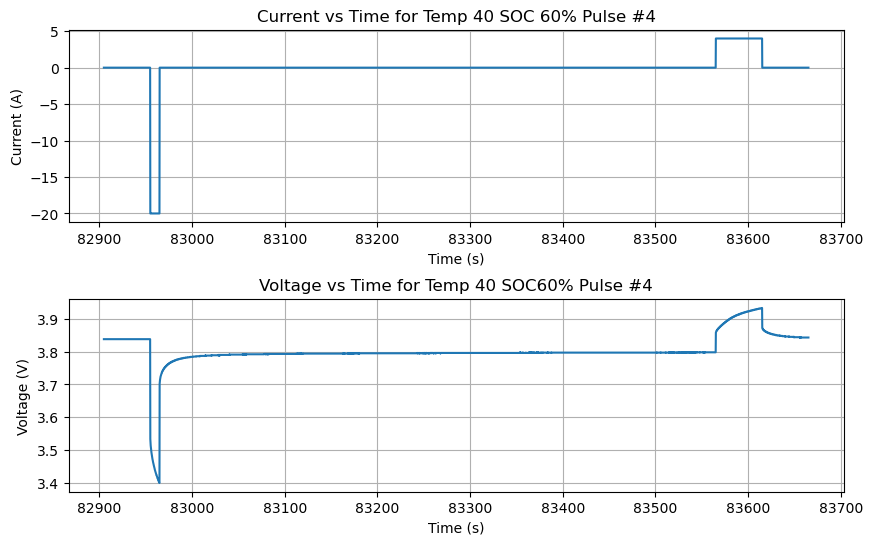

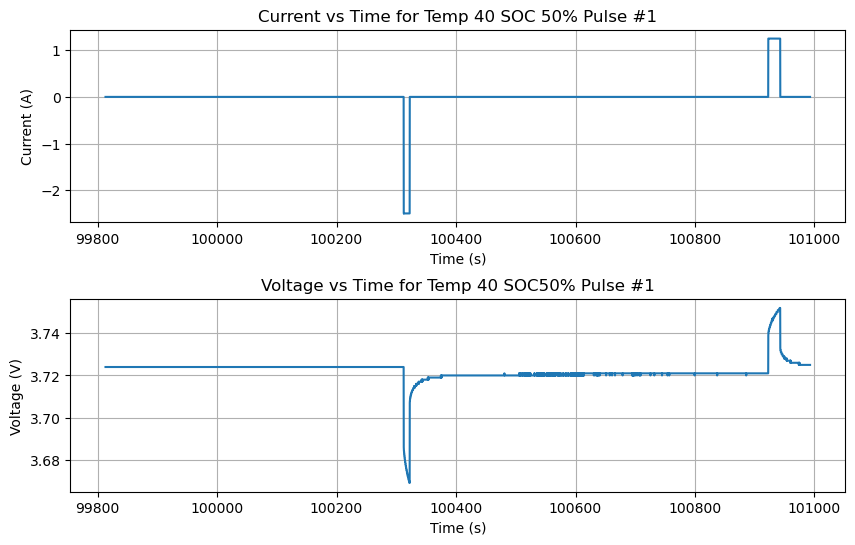

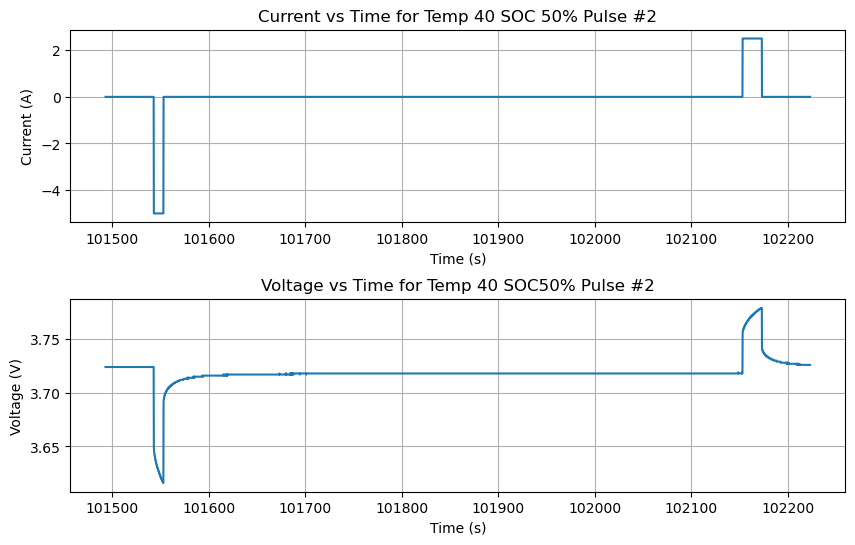

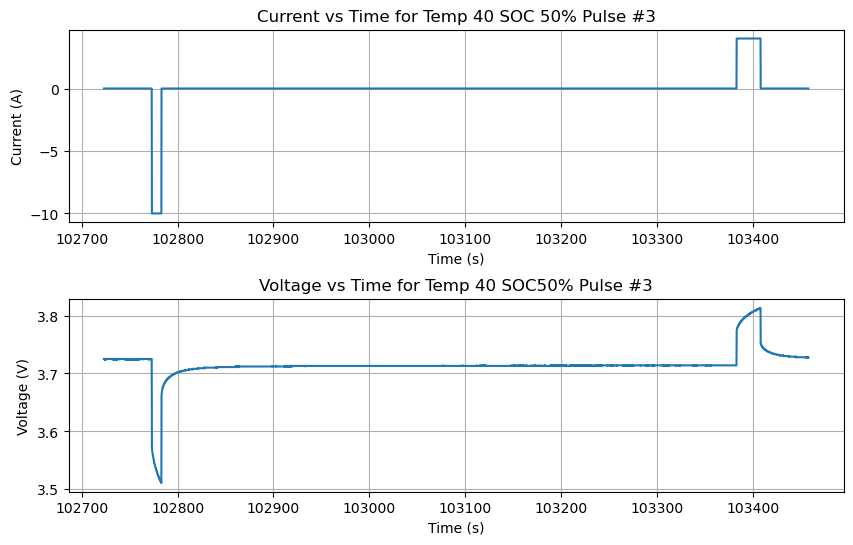

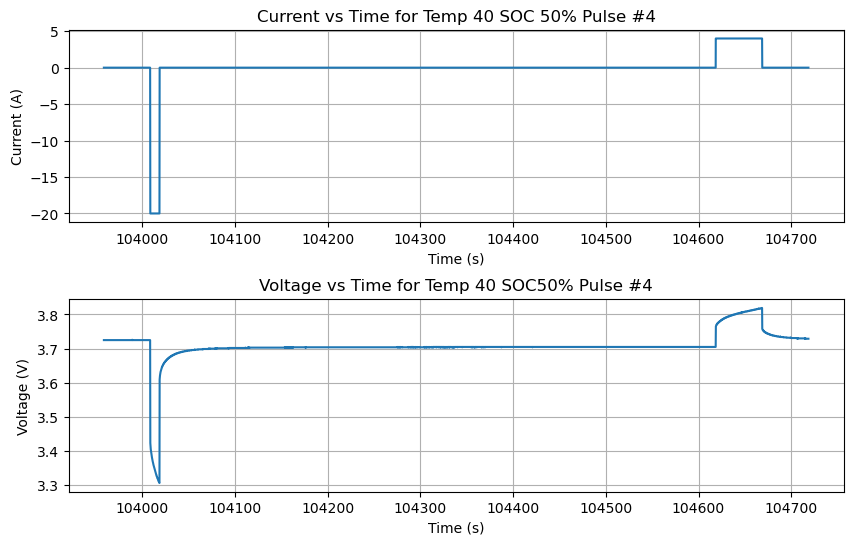

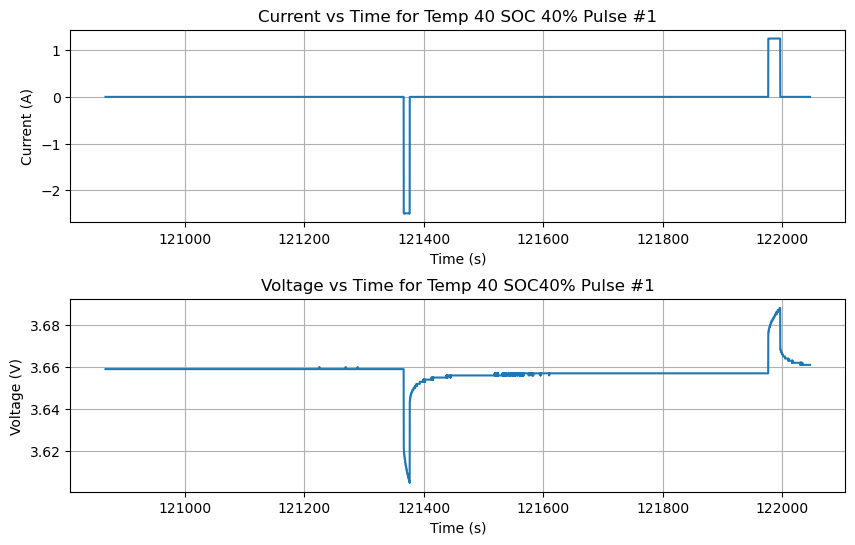

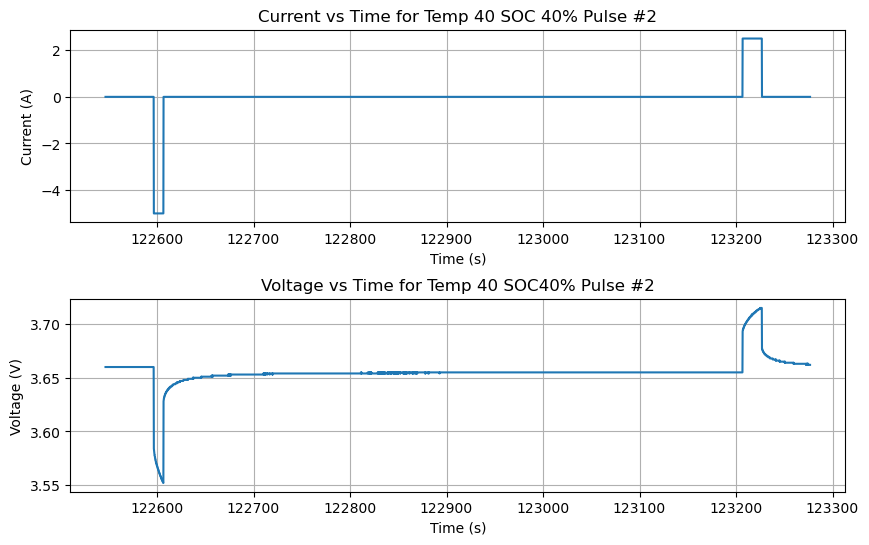

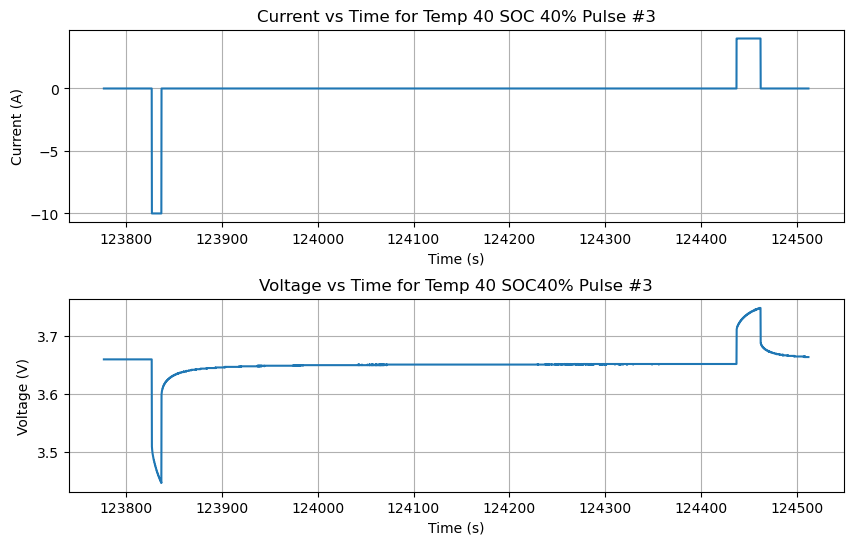

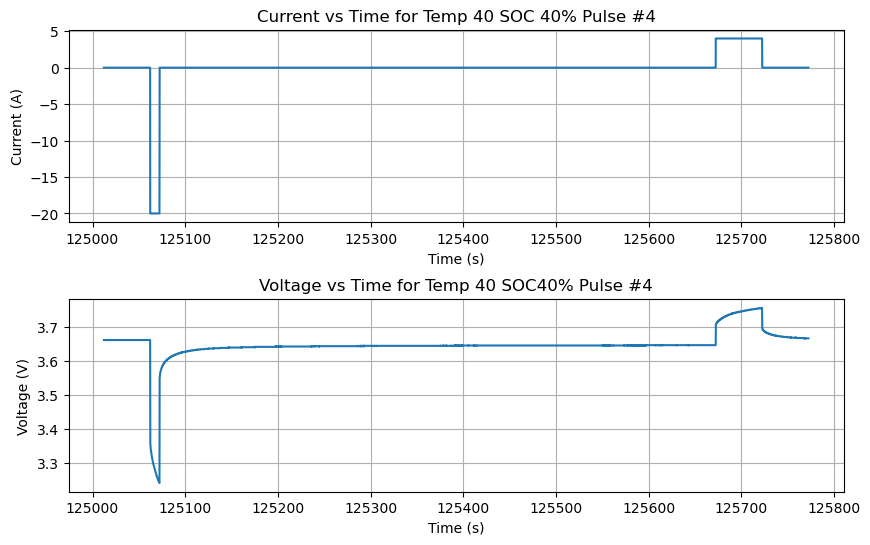

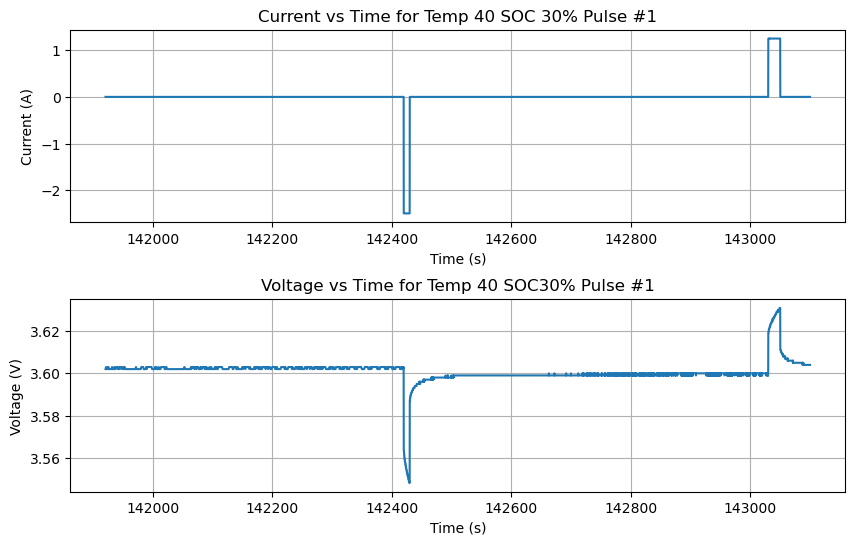

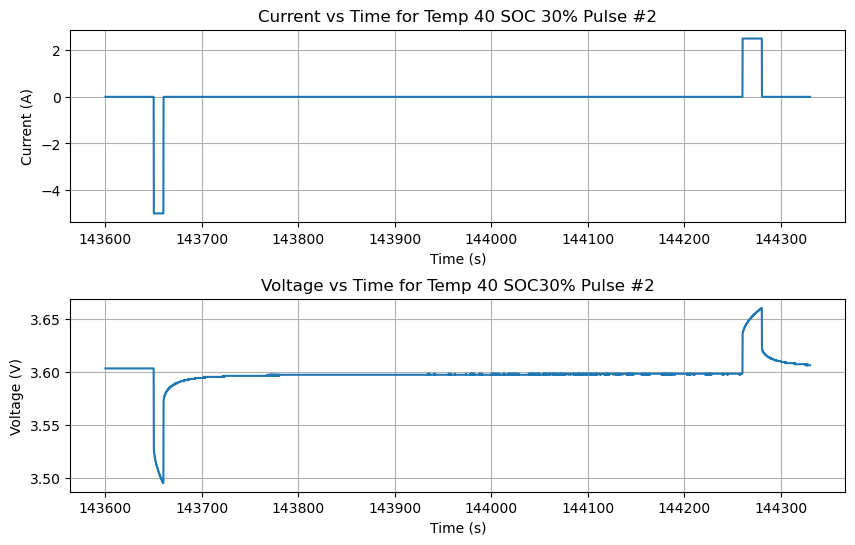

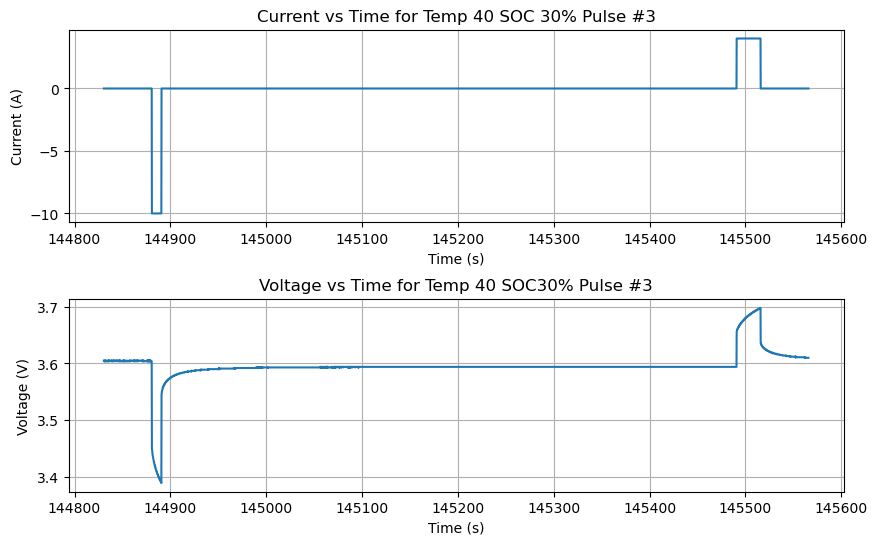

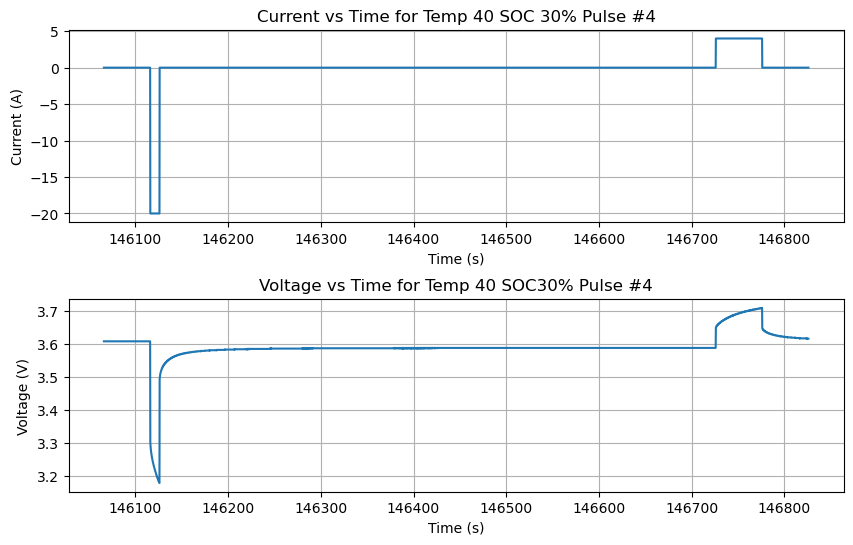

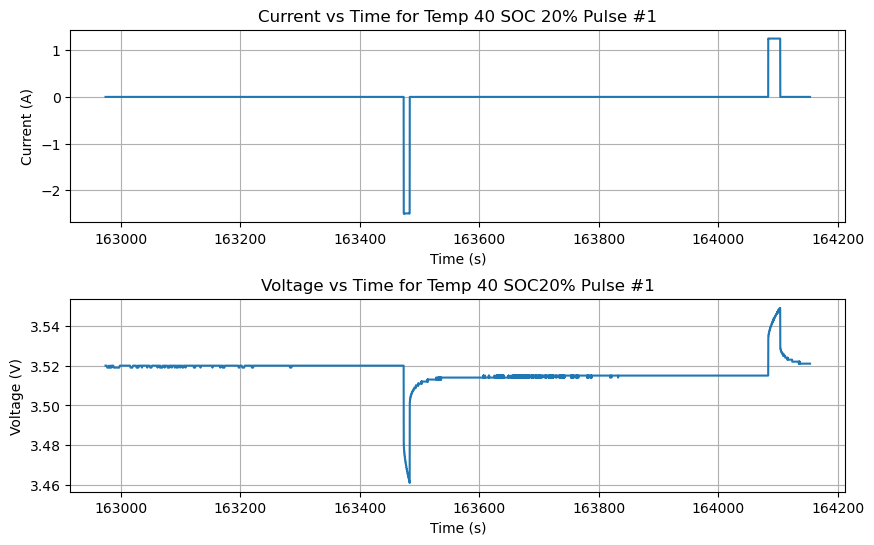

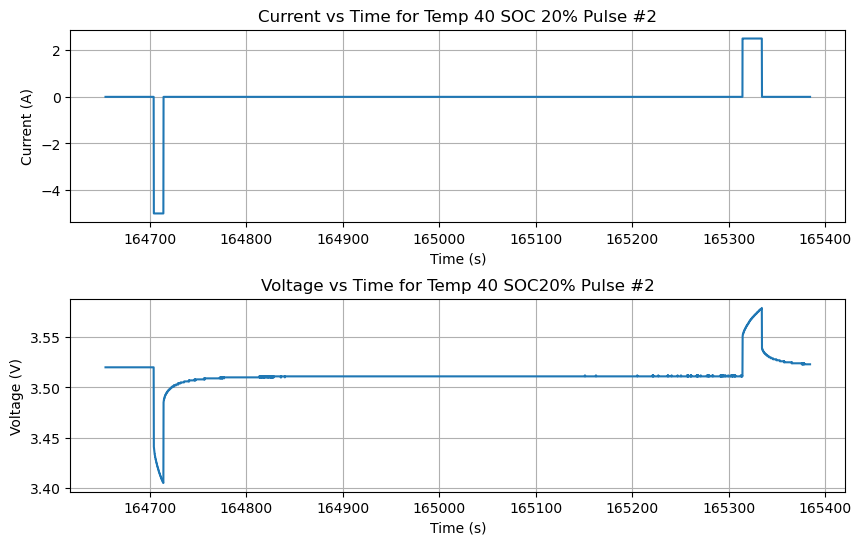

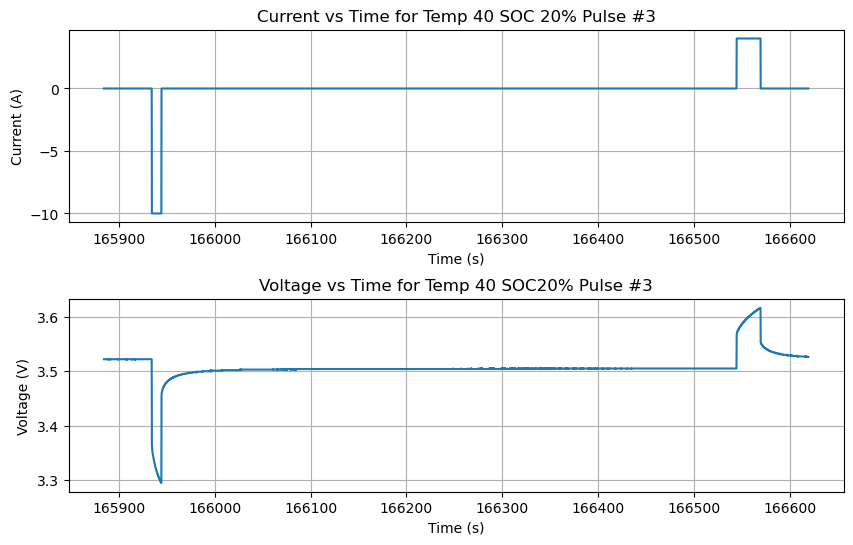

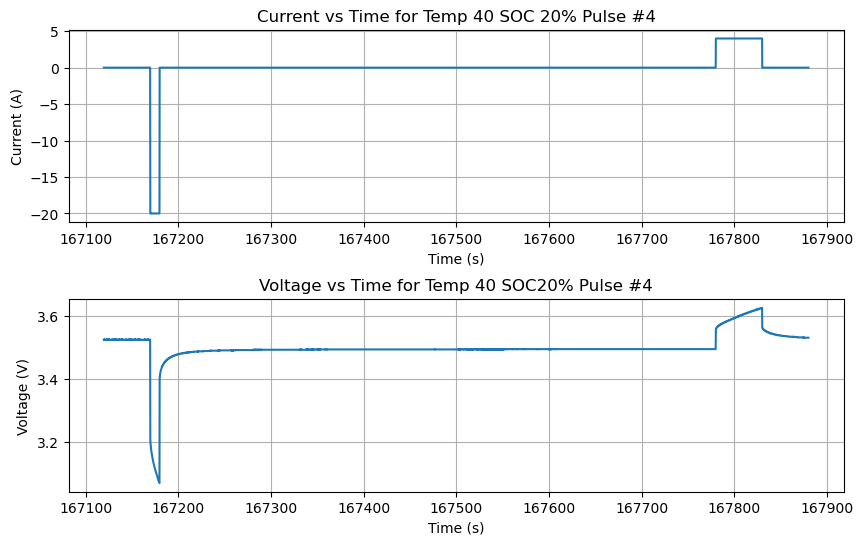

In [32]:
my_subs = plot_current_voltage(df_40, 40, color="r", overall_plot=False, subplots = False, subsubplots = True)

Need a way to automatically get the time indexes of the beginning of each charge and discharge cycle, as well as each soc


# 3. Save indices

Here I use the above functions to get a 3D matrix, where each element stores the start and end of an individual charge discharge test.
Dimensions are ordered as Temperature-SOC-Pulse, hence it is a 3-8-4 matrix

In [31]:
sub_matrix_0 = get_subsubsections(get_subsections(df_0,0),df_0)
sub_matrix_20 = get_subsubsections(get_subsections(df_20,20),df_20)
sub_matrix_40 = get_subsubsections(get_subsections(df_40,40),df_40)
del sub_matrix_0[-2] # handle extra row that's there for whatever reason
sub_matrices = [sub_matrix_0, sub_matrix_20, sub_matrix_40] 
# save sub_matrices to pickle file
import pickle
with open('Results\sub_matrices.pkl', 'wb') as f:
    pickle.dump(sub_matrices, f)
